In [1]:
import csv

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'

# 分類数設定

In [3]:
NUM_CLASSES = 11

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(
    dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(
    dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,191 (4.65 KB)

 Trainable params: 1,191 (4.65 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Callback de ponto de verificação do modelo
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para interrupção antecipada
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Compilação do modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
371/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1808 - loss: 2.2510
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1830 - loss: 2.2453 - val_accuracy: 0.4759 - val_loss: 1.5204
Epoch 2/1000
368/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3820 - loss: 1.6692
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3831 - loss: 1.6663 - val_accuracy: 0.6592 - val_loss: 1.0865
Epoch 3/1000
369/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4738 - loss: 1.4225
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4742 - loss: 1.4211 - val_accuracy: 0.7271 - val_loss: 0.8551
Epoch 4/1000
370/382 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5098 - loss: 1.2949
Epoch 4: saving model to model/keypoint_classifier/keypoint_classi

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8432 - loss: 0.5278


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[3.5469150e-04 2.3251564e-08 7.1745284e-02 7.5780070e-01 2.3635093e-06
 3.1673614e-04 1.7795695e-02 4.4152416e-02 4.4403208e-04 6.9587331e-05
 1.0731847e-01]
3


# 混同行列

509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step


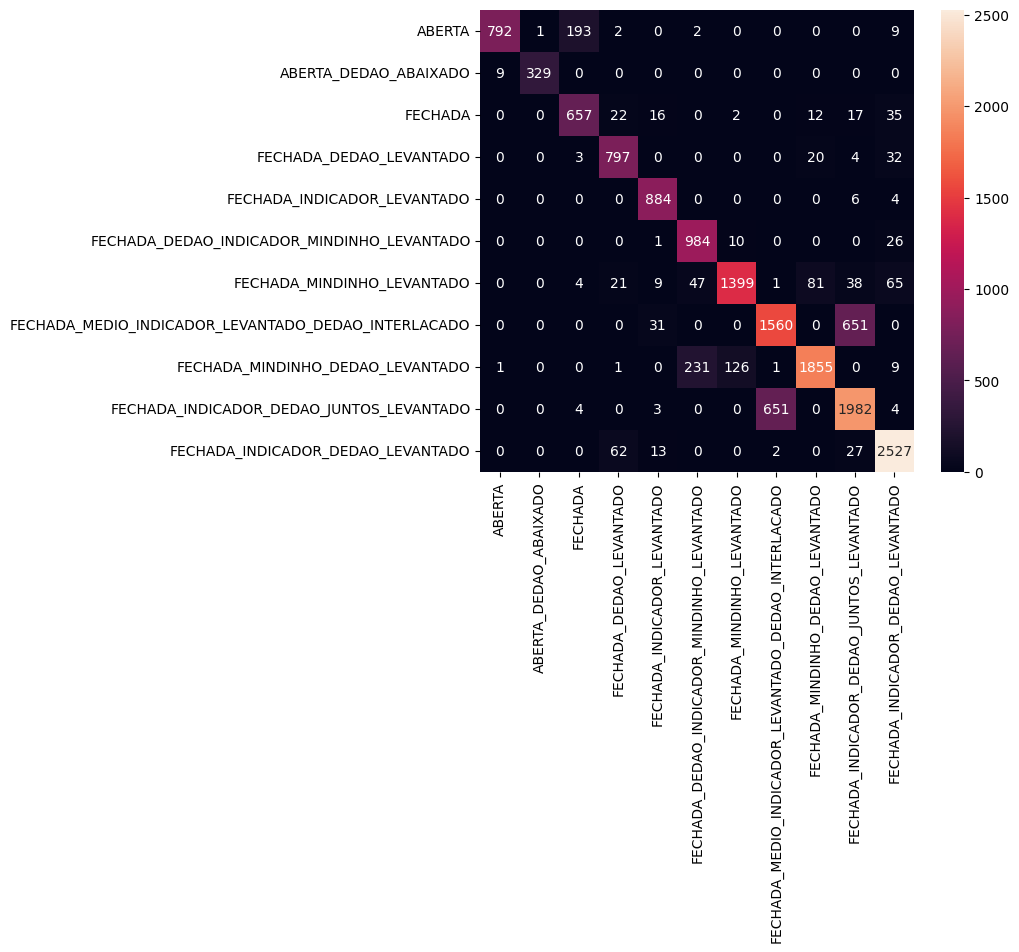

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.79      0.88       999
           1       1.00      0.97      0.99       338
           2       0.76      0.86      0.81       761
           3       0.88      0.93      0.91       856
           4       0.92      0.99      0.96       894
           5       0.78      0.96      0.86      1021
           6       0.91      0.84      0.87      1665
           7       0.70      0.70      0.70      2242
           8       0.94      0.83      0.89      2224
           9       0.73      0.75      0.74      2644
          10       0.93      0.96      0.95      2631

    accuracy                           0.85     16275
   macro avg       0.87      0.87      0.87     16275
weighted avg       0.85      0.85      0.85     16275



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    with open('model/keypoint_classifier/keypoint_classifier_label.csv',
            encoding='utf-8-sig') as f:
        keypoint_classifier_labels = csv.reader(f)
        keypoint_classifier_labels = [
            row[0] for row in keypoint_classifier_labels
        ]
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    labels = [keypoint_classifier_labels[i] for i in sorted(list(set(y_true)))]
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\DIOGOL~1\AppData\Local\Temp\tmp8vnjgo90\assets


INFO:tensorflow:Assets written to: C:\Users\DIOGOL~1\AppData\Local\Temp\tmp8vnjgo90\assets


Saved artifact at 'C:\Users\DIOGOL~1\AppData\Local\Temp\tmp8vnjgo90'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2312546067152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2312546068112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2312546068304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2312546069264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2312546069456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2312546070224: TensorSpec(shape=(), dtype=tf.resource, name=None)


6844

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.54691030e-04 2.32515234e-08 7.17451945e-02 7.57800817e-01
 2.36350502e-06 3.16735735e-04 1.77956726e-02 4.41524051e-02
 4.44032135e-04 6.95870767e-05 1.07318476e-01]
3
